In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt

# Library for multi-threading
import multiprocessing
from functools import partial

from ipynb.fs.full.Functions import generate_asset_payoff, generate_trader_valuation, generate_dealer_action, generate_q_matrix, duopoly_experiment

# Variable Setting

This is where we can set the variables of our economic environment. We can play around with these variables.

In [2]:
# Asset parameters
payoff_high = 6
prob_high = 0.5
payoff_low = -2
prob_low = 0.5
expected_payoff = payoff_high*prob_high + payoff_low*prob_low

# Dealer parameter
lowest_ask_price = 1
highest_ask_price = 15
possible_ask_price = np.arange(lowest_ask_price, highest_ask_price+1, 1)

# Trader parameters
private_valuation_mean = 0
private_valuation_sd = 5

# Learning parameters
alpha = 0.01
beta = 0.0008
lower_q = 3
upper_q = 6

# Number of Experiments and Episode
K = 100
T = 200000

# Duopoly Situation

Here, we run the simulation in the duopoly market maker situation, where there are two dealer in the market.

The function that sets up the whole environment are in "Functions.ipnyb". We need to put it in a seperate file for it to run on multiple threads. However, it is important to note that we need to have all variables of our experiment defined locally for the function to used.

In [3]:
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes = 10)

    # Set all other parameters other than k (random_seed) for the function "monopoly_experiment"
    func = partial(duopoly_experiment, 
                   payoff_high, prob_high, payoff_low, prob_low, lowest_ask_price, highest_ask_price, private_valuation_mean, private_valuation_sd, 
                   alpha, beta, lower_q, upper_q, T)
    
    # Run the function
    results = pool.map(func, np.arange(1,K+1,1))

 ProcessorSpawnPoolWorker-7 is processing k=100


# Results

We will now extract results into 2 different components.

First being the list of greedy prices in each experiment.

In [4]:
dealer_1_greedy_price_df = pd.DataFrame([item[0] for item in results]).T
dealer_1_greedy_price_df.columns = ["Experiment" + str(x) for x in np.arange(1,K+1,1)]

dealer_2_greedy_price_df = pd.DataFrame([item[1] for item in results]).T
dealer_2_greedy_price_df.columns = ["Experiment" + str(x) for x in np.arange(1,K+1,1)]

We also want the comparative statistics.

In [5]:
comparative_stats = pd.DataFrame({"trading_volume":[item[2] for item in results],
                                  "quoted_spread":[item[3] for item in results],
                                  "realized_spread":[item[4] for item in results]})

We can save the results locally.

In [2]:
#dealer_1_greedy_price_df.to_csv("./Duopoly_Simulation/duopoly_dealer_1_price.csv", index=False)
#dealer_2_greedy_price_df.to_csv("./Duopoly_Simulation/duopoly_dealer_2_price.csv", index=False)
#comparative_stats.to_csv("./Duopoly_Simulation/duopoly_stats_delta8.csv", index=False)

dealer_1_greedy_price_df = pd.read_csv("./Duopoly_Simulation/duopoly_dealer_1_price.csv")
dealer_2_greedy_price_df = pd.read_csv("./Duopoly_Simulation/duopoly_dealer_2_price.csv")

# Intepretation

Similarly, we will be analyzing the results here with graphs.

We first look at how the average greedy price changes over episodes for the two market marker. This gives us the idea of how the two market maker learns from each other and the environment.

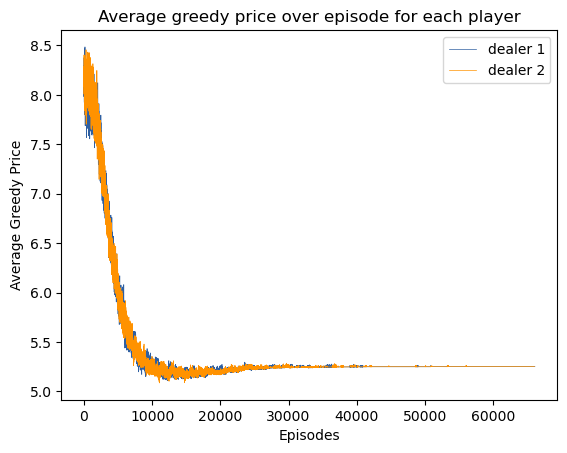

In [3]:
plt.title("Average greedy price over episode for each player")
plt.plot(dealer_1_greedy_price_df.ffill().mean(axis = 1), color = "#2e5fa1", linewidth = 0.5, label = "dealer 1")
plt.plot(dealer_2_greedy_price_df.ffill().mean(axis = 1), color = "#ff9200", linewidth = 0.5, label = "dealer 2")
plt.xlabel("Episodes")
plt.ylabel("Average Greedy Price")
plt.legend(loc = "upper right")
plt.savefig("./Figures/Duopoly average greedy price over time for each player.png")
plt.show()

We are also interested in the final greedy price market makers arrives in.

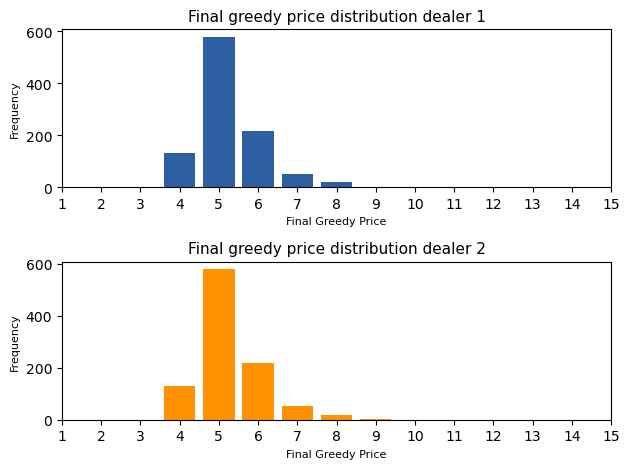

In [4]:
dealer_1_greedy_prices, dealer_1_greedy_prices_freq = np.unique(dealer_1_greedy_price_df.ffill(axis = 0).iloc[-1,:], return_counts = True)
dealer_2_greedy_prices, dealer_2_greedy_prices_freq = np.unique(dealer_2_greedy_price_df.ffill(axis = 0).iloc[-1,:], return_counts = True)

fig, axs = plt.subplots(nrows = 2, ncols = 1)
axs[0].bar(dealer_1_greedy_prices, dealer_1_greedy_prices_freq, color = "#2e5fa1")
axs[0].set_title("Final greedy price distribution dealer 1", fontsize = 11)
axs[0].set_xlabel("Final Greedy Price", fontsize = 8)
axs[0].set_ylabel("Frequency", fontsize = 8)
axs[0].set_xticks(np.arange(1,16,1))

axs[1].bar(dealer_2_greedy_prices, dealer_2_greedy_prices_freq, color = "#ff9200")
axs[1].set_title("Final greedy price distribution dealer 2", fontsize = 11)
axs[1].set_xlabel("Final Greedy Price", fontsize = 8)
axs[1].set_ylabel("Frequency", fontsize = 8)
axs[1].set_xticks(np.arange(1,16,1))

fig.tight_layout()

plt.savefig("./Figures/Duopoly final greedy price distribution for each player.png")
plt.show()